In [1]:
import numpy  as np
import sympy  as sym

import matplotlib.pyplot as plt
import scipy.sparse      as sparse

import utilitis_FEEC.evaluation as eva
import utilitis_FEEC.bsplines   as bsp

import utilitis_FEEC.projections_mhd as mhd
import utilitis_FEEC.projectors_opt  as proj
import utilitis_FEEC.derivatives     as der

import utilitis_FEEC.mass_matrices_stencil as mass

In [1]:
# ... define boundary conditions in each direction (True: periodic, False: else)
bc = [True, True, True]
bc_1, bc_2, bc_3 = bc


# ... number of elements and element boundaries in each direction
Nel_1 = 4
Nel_2 = 8
Nel_3 = 32

el_b_1 = np.linspace(0., 1., Nel_1 + 1)
el_b_2 = np.linspace(0., 1., Nel_2 + 1)
el_b_3 = np.linspace(0., 1., Nel_3 + 1)

# ... degree of spline basis (of the 0-forms) in each direction
p = [3, 3, 3]
p1, p2, p3 = p


# ... geometry
mapping = 'cube'


# ... number of basis functions
Nbase = [Nel_1 + p1, Nel_2 + p2, Nel_3 + p3] 
Nbase_1, Nbase_2, Nbase_3 = Nbase


# ... knot vectors
T1 = bsp.make_knots(el_b_1, p1, bc_1)
T2 = bsp.make_knots(el_b_2, p2, bc_2)
T3 = bsp.make_knots(el_b_3, p3, bc_3)    
T = [T1, T2, T3]

# ... greville points
greville_1 = bsp.greville(T1, p1, bc_1) + p1%2*1e-15
greville_2 = bsp.greville(T2, p2, bc_2) + p2%2*1e-15
greville_3 = bsp.greville(T3, p3, bc_3) + p3%2*1e-15



# ... define physical domain and mapping from logical domain
if mapping == 'annulus':
    
    # ... coordinates
    r, phi, z = sym.symbols('r, phi, z')
    q = sym.Matrix([r, phi, z])
    
    # ... mapping
    R1 = 0.2         # inner radius
    R2 = 1.0         # outer radius
    dR = R2 - R1     # thickness
    
    F = sym.Matrix([(r*dR + R1)*sym.cos(2*sym.pi*phi), (r*dR + R1)*sym.sin(2*sym.pi*phi), z])
    
elif mapping == 'torus':
    
    # ... coordinates
    r, theta, phi = sym.symbols('r, theta, phi')
    q = sym.Matrix([r, theta, phi])

    # ... mapping
    R0 = 1.5         # major radius
    R1 = 0.2         # inner radius
    R2 = 1.0         # outer radius
    dR = R2 - R1     # thickness
    
    F = sym.Matrix([(R0 + (r*dR + R1)*sym.cos(2*sym.pi*theta))*sym.cos(2*sym.pi*phi), (R0 + (r*dR + R1)*sym.cos(2*sym.pi*theta))*sym.sin(2*sym.pi*phi), (r*dR + R1)*sym.sin(2*sym.pi*theta)])
    
elif mapping == 'cube':
    
    # ... coordinates
    x, y, z = sym.symbols('x, y, z')
    q = sym.Matrix([x, y, z])
    
    # ... mapping
    Lx = 1.           # length in x
    Ly = 1.           # length in y
    Lz = 1.           # length in z
    
    F = sym.Matrix([Lx*x, Ly*y, Lz*z])
    

# ... jacobian matrix
DF = F.jacobian(q)

# ... metric tensor
G = sym.simplify(DF.transpose()*DF)

# ... inverse of metric tensor
Ginv = G.inverse()

#... square root of jacobi determinant
g = sym.simplify(G.det())
g_sqrt = sym.sqrt(g)


# ... convert mapping functions to callables
xc = sym.lambdify(q, F[0])
yc = sym.lambdify(q, F[1])
zc = sym.lambdify(q, F[2])

G      = [[sym.lambdify(q, G[0, 0]), sym.lambdify(q, G[0, 1]), sym.lambdify(q, G[0, 2])], [sym.lambdify(q, G[1, 0]), sym.lambdify(q, G[1, 1]), sym.lambdify(q, G[1, 2])], [sym.lambdify(q, G[2, 0]), sym.lambdify(q, G[2, 1]), sym.lambdify(q, G[2, 2])]]
Ginv   = [[sym.lambdify(q, Ginv[0, 0]), sym.lambdify(q, Ginv[0, 1]), sym.lambdify(q, Ginv[0, 2])], [sym.lambdify(q, Ginv[1, 0]), sym.lambdify(q, Ginv[1, 1]), sym.lambdify(q, Ginv[1, 2])], [sym.lambdify(q, Ginv[2, 0]), sym.lambdify(q, Ginv[2, 1]), sym.lambdify(q, Ginv[2, 2])]]
g      = sym.lambdify(q, g)
g_sqrt = sym.lambdify(q, g_sqrt)


# ... physical input parameters for homogeneous equlibrium
r0 = 1.
p0 = 1.
B01 = 0.
B02 = 0.
B03 = 1.

rho0 = lambda q1, q2, q3 : r0 * np.ones(q1.shape)     # ... eq. mass density of plasma
pr0  = lambda q1, q2, q3 : p0 * np.ones(q1.shape)     # ... eq. pressure of plasma

B0_1 = lambda q1, q2, q3 : B01 * np.ones(q1.shape)    # ... background magnetic field in 1 - direction
B0_2 = lambda q1, q2, q3 : B02 * np.ones(q1.shape)    # ... background magnetic field in 2 - direction
B0_3 = lambda q1, q2, q3 : B03 * np.ones(q1.shape)    # ... background magnetic field in 3 - direction

gamma = 5/3                                           # ... adiabatic exponent
cs = np.sqrt(gamma*p0/(2*r0))                         # ... speed of sound
vA = np.sqrt((B01**2 + B02**2 + B03**2)/r0)           # ... Alfvén-velocity



# ... dispersion relation
def omega(k, pol):
    
    delta = (4*B03**2*cs**2*vA**2)/((cs**2 + vA**2)**2*(B01**2 + B02**2 + B03**2))
    
    return np.sqrt(1/2*k**2*(cs**2 + vA**2)*(1 + pol*np.sqrt(1 - delta)))
# ...



# ... initial conditions
amp = 0.1                                             # ... characteristic amplitude of pertubations
kz  = 2                                               # ... wavenumber of initial pertubation
w   = omega(kz, +1)                                   # ... frequency of wave
vph = w/kz                                            # ... phase velocity


u1_ini = lambda q1, q2, q3 : 0 * np.ones(q1.shape)
u2_ini = lambda q1, q2, q3 : amp * np.sin(2*np.pi*kz*q3)
u3_ini = lambda q1, q2, q3 : 0 * np.ones(q1.shape)

B1_ini = lambda q1, q2, q3 : 0 * np.ones(q1.shape)
B2_ini = lambda q1, q2, q3 : -kz*B03/w * amp * np.sin(2*np.pi*kz*q3)
B3_ini = lambda q1, q2, q3 : 0 * np.ones(q1.shape)

rh_ini = lambda q1, q2, q3 : 0 * np.ones(q1.shape)
pr_ini = lambda q1, q2, q3 : np.random.rand(1)

NameError: name 'np' is not defined

In [216]:
der.GRAD_1d(p1, Nbase_1, bc_1)

array([[-1.,  1.,  0.,  0.],
       [ 0., -1.,  1.,  0.],
       [ 0.,  0., -1.,  1.],
       [ 1.,  0.,  0., -1.]])

In [4]:
MHD = mhd.projections_mhd(p, Nbase, T, bc)

MHD.assemble_equilibrium_B(Ginv, [B0_1, B0_2, B0_3])

In [5]:
PRO = proj.projectors_3d(p, Nbase, T, bc)

PRO.assemble_V0()
PRO.assemble_V1()
PRO.assemble_V2()

In [6]:
# projection of initial conditions
u1_ini_vec, u2_ini_vec, u3_ini_vec = PRO.PI_1([u1_ini, u2_ini, u3_ini])
B1_ini_vec, B2_ini_vec, B3_ini_vec = PRO.PI_2([B1_ini, B2_ini, B3_ini])

In [8]:
zplot = np.linspace(0., 1., 100)

uplot1, uplot2, uplot3 = eva.evaluate_field_V1_3d([u1_ini_vec, u2_ini_vec, u3_ini_vec], [np.array([0.]), np.array([0.]), zplot], p, Nbase, T, bc)
Bplot1, Bplot2, Bplot3 = eva.evaluate_field_V2_3d([B1_ini_vec, B2_ini_vec, B3_ini_vec], [np.array([0.]), np.array([0.]), zplot], p, Nbase, T, bc)

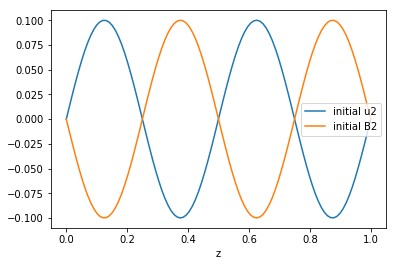

In [9]:
plt.plot(zplot, uplot2, label='initial u2')
plt.plot(zplot, Bplot2, label='initial B2')

plt.xlabel('z')
plt.legend()

In [10]:
# inter - hisotpolation matrices in V1
pi11 = PRO.interhistopolation_V1_1
pi12 = PRO.interhistopolation_V1_2
pi13 = PRO.interhistopolation_V1_3

In [11]:
# inter - hisotpolation matrices in V1 (LU - factorized)
pi11_LU = PRO.interhistopolation_V1_1_LU
pi12_LU = PRO.interhistopolation_V1_2_LU
pi13_LU = PRO.interhistopolation_V1_3_LU

In [211]:
# discrete curl and divergence matrix
CURL = der.CURL_3d(p, Nbase, bc)
DIV  = der.DIV_3d(p, Nbase, bc)

In [13]:
# mass matrices and spaces in V1 and V2
M1, V1 = mass.mass_matrix_V1(p, Nbase, T, Ginv, g_sqrt, bc)
M2, V2 = mass.mass_matrix_V2(p, Nbase, T, G, g_sqrt, bc)

In [14]:
# block matrices
from psydac.linalg.block import BlockMatrix

M1 = BlockMatrix(V1, V1, blocks=M1).tosparse().tocsc()
M2 = BlockMatrix(V2, V2, blocks=M2).tosparse().tocsc()

In [25]:
# LU decomposition of M1
M1_LU = sparse.linalg.splu(M1)

In [15]:
# Projection matrix P11 (right-hand sides for all basis functions)
P11_1, P11_2, P11_3 = MHD.assembly_B([B0_1, B0_2, B0_3], Ginv)

In [17]:
# Perform projection of PA
P11_1 = sparse.linalg.spsolve(pi11, P11_1)
P11_2 = sparse.linalg.spsolve(pi12, P11_2)
P11_3 = sparse.linalg.spsolve(pi13, P11_3)

In [19]:
# construct block matrices
P11 = sparse.bmat([[P11_1], [P11_2], [P11_3]], format='csr')

In [179]:
mat1 = sparse.bmat([[None, sparse.linalg.inv(M1).dot(P11.T.dot(CURL.T.dot(M2)))], [-CURL.dot(P11), None]], format='csc')

mat1_LU = sparse.linalg.splu(sparse.identity(len(B_vec) + len(u_vec), format='csc') - dt/2*mat1)
mat2    = sparse.identity(len(B_vec) + len(u_vec)) + dt/2*mat1

In [165]:
# time integration by a time step dt using Hamiltonian splitting
def update(B_vec, u_vec, H):
    
    B_vec_new = B_vec - dt * CURL.dot(P11.dot(u_vec))
    u_vec_new = u_vec + dt * M1_LU.solve(P11.T.dot(CURL.T.dot(M2.dot(B_vec_new))))
    
    H = np.append(H, 1/2*u_vec_new.T.dot(M1.dot(u_vec_new)) + 1/2*B_vec_new.T.dot(M2.dot(B_vec_new)))
    
    return B_vec_new, u_vec_new, H

In [202]:
# time integration by a time step dt using Crank Nicolson
def update(B_vec, u_vec, H):
    
    vec = np.concatenate((u_vec, B_vec))
    
    vec_new = mat1_LU.solve(mat2.dot(vec))
    
    u_vec_new, B_vec_new = np.split(vec_new, 2)
    
    H = np.append(H, 1/2*u_vec_new.T.dot(M1.dot(u_vec_new)) + 1/2*B_vec_new.T.dot(M2.dot(B_vec_new)))
    
    return B_vec_new, u_vec_new, H

In [203]:
dt = 0.01

In [204]:
B_vec = np.concatenate((B1_ini_vec, B2_ini_vec, B3_ini_vec))
u_vec = np.concatenate((u1_ini_vec, u2_ini_vec, u3_ini_vec))
H     = np.array([1/2*u_vec.T.dot(M1.dot(u_vec)) + 1/2*B_vec.T.dot(M2.dot(B_vec))])

In [205]:
for i in range(100):

    B_vec, u_vec, H = update(B_vec, u_vec, H)

In [206]:
uplot1, uplot2, uplot3 = eva.evaluate_field_V1_3d(np.split(u_vec, 3), [np.array([0.]), np.array([0.]), zplot], p, Nbase, T, bc)
Bplot1, Bplot2, Bplot3 = eva.evaluate_field_V2_3d(np.split(B_vec, 3), [np.array([0.]), np.array([0.]), zplot], p, Nbase, T, bc)

(-0.11, 0.11)

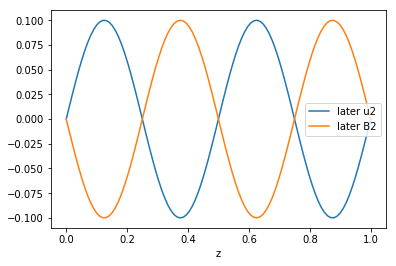

In [207]:
plt.plot(zplot, uplot2, label='later u2')
plt.plot(zplot, Bplot2, label='later B2')

plt.xlabel('z')
plt.legend()
plt.ylim((-0.11, 0.11))

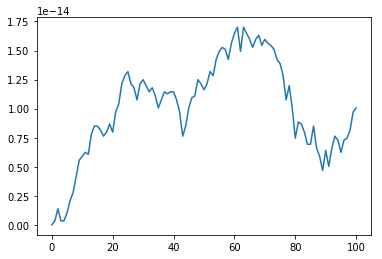

In [208]:
plt.plot(np.abs((H - H[0]))/H[0])

In [209]:
sparse.linalg.inv(M1)

<3072x3072 sparse matrix of type '<class 'numpy.float64'>'
	with 3145728 stored elements in Compressed Sparse Column format>

In [213]:
np.split(B_vec, 3)

[array([ 5.26747334e-33,  8.66206213e-35,  4.56964520e-33, ...,
         1.09111992e-32, -6.96346768e-33,  5.80876478e-33]),
 array([ 0.00015377, -0.00015699, -0.00044385, ...,  0.00078082,
         0.00066131,  0.00044111]),
 array([-2.07597332e-17,  1.25757075e-17,  4.30167278e-17, ...,
         7.30959556e-17,  4.58077414e-17,  2.47818639e-17])]